## Loading Financial Data

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from datetime import timedelta

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler                # Scale the data between 0 and 1
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [2]:
import pymysql
import mysql.connector

In [90]:
crypto_currency = 'LTC'
against_currency = 'USD'

In [91]:
start = dt.datetime(2015,1,1)
end = dt.datetime.now()

In [92]:
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [93]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,2.72421,2.68977,2.72421,2.69905,770693,2.69905
2015-01-02,2.69924,2.66385,2.69743,2.66736,855392,2.66736
2015-01-03,2.66646,2.13316,2.66646,2.13316,5193080,2.13316
2015-01-04,2.15446,1.91241,2.11022,1.95668,3888140,1.95668
2015-01-05,2.16048,1.95803,1.95803,2.08218,10649500,2.08218


## Data Preparation

In [94]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [95]:
# Number of days where the prediction is based on
prediction_days = 60
#future_day = 7

In [96]:
# Train Data
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)): # - future_day):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])  # + future_days

In [97]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Model Layers

In [98]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) 

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
82/82 [==============================] - 8s 54ms/step - loss: 0.0064
Epoch 2/25
82/82 [==============================] - 4s 53ms/step - loss: 0.0032
Epoch 3/25
82/82 [==============================] - 4s 54ms/step - loss: 0.0027
Epoch 4/25
82/82 [==============================] - 4s 52ms/step - loss: 0.0023
Epoch 5/25
82/82 [==============================] - 4s 53ms/step - loss: 0.0020
Epoch 6/25
82/82 [==============================] - 4s 53ms/step - loss: 0.0017
Epoch 7/25
82/82 [==============================] - 4s 53ms/step - loss: 0.0016
Epoch 8/25
82/82 [==============================] - 4s 54ms/step - loss: 0.0016
Epoch 9/25
82/82 [==============================] - 4s 53ms/step - loss: 0.0016
Epoch 10/25
82/82 [==============================] - 4s 54ms/step - loss: 0.0015
Epoch 11/25
82/82 [==============================] - 4s 52ms/step - loss: 0.0014
Epoch 12/25
82/82 [==============================] - 4s 52ms/step - loss: 0.0013
Epoch 13/25
82/82 [==================

## Testing the Model

In [99]:
test_start = dt.datetime(2017,1,1)   # Starts date of the data
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

In [100]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

In [101]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [102]:
len(model_inputs)

2001

In [103]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [104]:
# Predict Prices
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

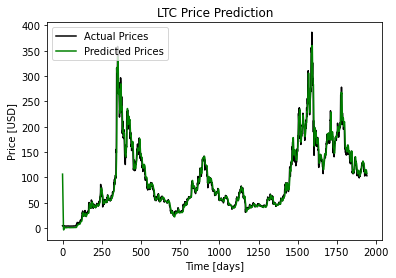

In [105]:
# Plotting
plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
plt.plot(prediction_prices, color = 'green', label = 'Predicted Prices')
plt.title(f'{crypto_currency} Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend(loc = 'upper left')
plt.show()

In [106]:
next_day_prediction = []

next_day_prediction = [(end + timedelta(1)).strftime('%Y-%m-%d'), prediction_prices[-1]]

print(next_day_prediction)

['2022-04-26', array([107.821205], dtype=float32)]


In [61]:
next_day_prediction[1][0]

39887.938

In [27]:
prediction_prices.shape

(1941, 1)

In [55]:
def insert_data(date, type, close):
    try:
        connection = mysql.connector.connect(host = 'localhost',
                                           database = 'cs540_project',
                                           user = 'root',
                                           password = '')
        cursor = connection.cursor()
        mySql_insert_query = """INSERT INTO prediction (Date, Type, Close)
                                VALUES (%s, %s, %s)"""
        
        prediction = (date, type, close)
        print(prediction)
        cursor.execute(mySql_insert_query, prediction)
        connection.commit()
        
    except mysql.connector.Error as error:
        print('Failed {}'.format(error))
        
    #finally:
     #   if connection.is_connected():
      #      cursor.close()
       #     connection.close()

In [63]:
insert_data(next_day_prediction[0], 'BTC', float(next_day_prediction[1][0]))

('2022-04-26', 'BTC', 39887.9375)


In [82]:
insert_data(next_day_prediction[0], 'ETH', float(next_day_prediction[1][0]))

('2022-04-26', 'ETH', 3090.508544921875)


In [107]:
insert_data(next_day_prediction[0], 'LTC', float(next_day_prediction[1][0]))

('2022-04-26', 'LTC', 107.82120513916016)
